## 1. Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
import pickle
import squarify
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

## 2. Load file RFM and stats

In [2]:
df = pd.read_csv('df_RFM.csv')
df.head(3)

,Member_number,Recency,Frequency,Monetary
0,2433,3,31,375.31
1,2193,91,27,361.45
2,1793,26,25,345.10


In [3]:
df.describe()

,Member_number,Recency,Frequency,Monetary
count,3898.000000,3898.000000,3898.000000,3898.000000
mean,3002.959979,187.701385,9.944844,85.212835
std,1155.806001,159.912688,5.310796,55.620089
min,1000.000000,0.000000,2.000000,1.300000
25%,1999.250000,57.000000,6.000000,43.810000
50%,3004.500000,141.000000,9.000000,74.900000
75%,4002.750000,280.000000,13.000000,115.295000
max,5000.000000,727.000000,36.000000,375.310000


In [4]:
#confirm null values and duplicate values
print(f"There has {df.isna().sum()} null values")
print(f"There has {df.duplicated().sum()} duplicated values")

There has Member_number    0
Recency          0
Frequency        0
Monetary         0
dtype: int64 null values
There has 0 duplicated values


## 3. Scale data and training model

#### 3.1. Scale data

In [5]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['Recency', 'Frequency', 'Monetary']])

##### 3.2. Elbow method and Silhouette Score

* GMM

In [6]:
silhouette_scores_gmm = []
bic_scores = []
aic_scores = []
k_values = range(2, 11)

for k in k_values:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(scaled_data)
    gmm_labels = gmm.predict(scaled_data)
    silhouette_scores_gmm.append(silhouette_score(scaled_data, gmm_labels))
    bic_scores.append(gmm.bic(scaled_data))
    aic_scores.append(gmm.aic(scaled_data))

C:\Users\triet\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 指定されたファイルが見つかりません。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\triet\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\triet\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\triet\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\triet\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1456, 

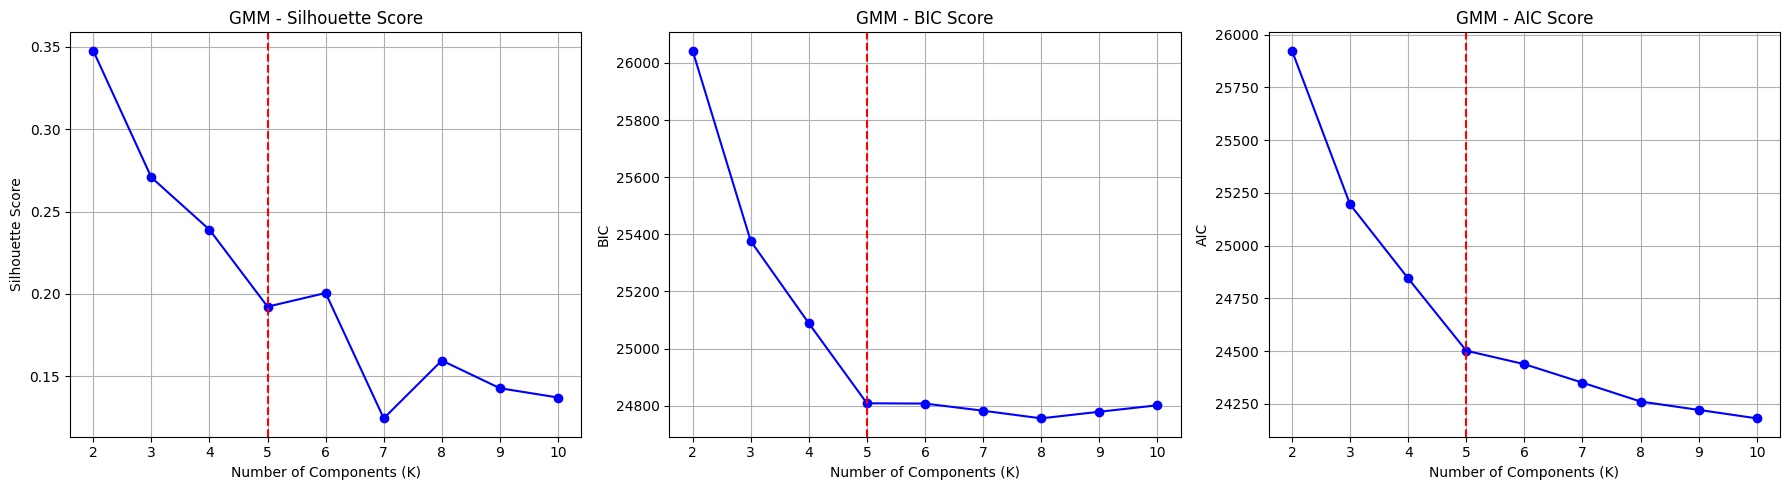

In [7]:
plt.figure(figsize=(18, 5))
# Silhouette Score Plot
plt.subplot(1, 3, 1)
plt.plot(k_values, silhouette_scores_gmm, marker='o', color='b')
plt.axvline(x=5, color='r', linestyle='--', label=f'Optimal k = 5')
plt.title("GMM - Silhouette Score")
plt.xlabel("Number of Components (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)

# BIC Plot
plt.subplot(1, 3, 2)
plt.plot(k_values, bic_scores, marker='o', color='b')
plt.axvline(x=5, color='r', linestyle='--', label=f'Optimal k = 5')
plt.title("GMM - BIC Score")
plt.xlabel("Number of Components (K)")
plt.ylabel("BIC")
plt.grid(True)

# AIC Plot
plt.subplot(1, 3, 3)
plt.plot(k_values, aic_scores, marker='o', color='b')
plt.axvline(x=5, color='r', linestyle='--', label=f'Optimal k = 5')
plt.title("GMM - AIC Score")
plt.xlabel("Number of Components (K)")
plt.ylabel("AIC")
plt.grid(True)

plt.tight_layout()
plt.show()

* Conclusion

**Comment:**
- Both BIC and AIC significantly decrease up to k = 5, then flatten, indicating diminishing model improvement. 
- The silhouette score at k = 5 remains reasonably high, balancing model fit and cluster separability.
- k = 5 offers a good trade-off between complexity and performance.

In [8]:
k = 5
k_index = k_values.index(k)
print(f"*GMM - k = {k}:")
print(f"  Silhouette Score: {round(silhouette_scores_gmm[k_index],2)}")
print(f"  BIC: {round(bic_scores[k_index],2)}")
print(f"  AIC: {round(aic_scores[k_index],2)}")

*GMM - k = 5:
  Silhouette Score: 0.19
  BIC: 24808.64
  AIC: 24501.5


#### 3.2. Train models

In [9]:
start_time = time.time()

In [10]:
k = 5
gmm_model = GaussianMixture(n_components=k, random_state=42)
gmm_model.fit(scaled_data)

GaussianMixture(n_components=5, random_state=42)

In [11]:
end_time_1 = time.time()

In [12]:
df['cluster'] = gmm_model.predict(scaled_data)

In [13]:
end_time_2 = time.time()

In [14]:
print ("model training time:", round(end_time_1 - start_time,3),"sec")
print ("Prediction time:", round(end_time_2-end_time_1,3),"sec")

model training time: 2.828 sec
Prediction time: 0.03 sec


#### 3.3. Customer clustering visualization

* GMM

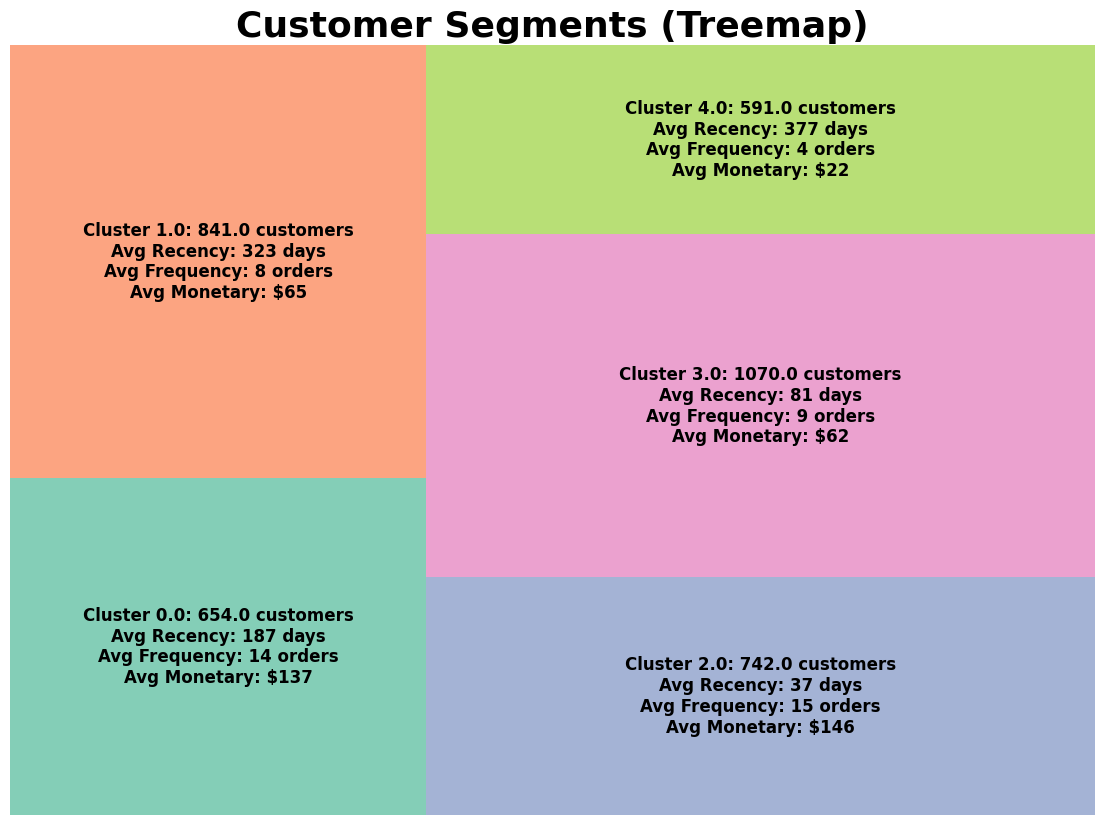

In [15]:
# Cluster summary
cluster_summary = df.groupby('cluster').agg(
    Count=('cluster', 'size'),
    Avg_Recency=('Recency', 'mean'),
    Avg_Frequency=('Frequency', 'mean'),
    Avg_Monetary=('Monetary', 'mean')
).reset_index()

# Create labels
cluster_summary['label'] = [
    f"Cluster {row['cluster']}: {row['Count']} customers\nAvg Recency: {row['Avg_Recency']:.0f} days\nAvg Frequency: {row['Avg_Frequency']:.0f} orders\nAvg Monetary: ${row['Avg_Monetary']:.0f}"
    for _, row in cluster_summary.iterrows()
]

num_clusters = cluster_summary.shape[0]
colors = sns.color_palette("Set2", n_colors=num_clusters).as_hex()  

# Plot treemap with colors
fig = plt.figure(figsize=(14, 10))
squarify.plot(
    sizes=cluster_summary['Count'],
    label=cluster_summary['label'],
    color=colors,
    text_kwargs={'fontsize': 12, 'weight': 'bold', 'fontname': "sans serif"},
    alpha=0.8
)

plt.title("Customer Segments (Treemap)", fontsize=26, fontweight="bold")
plt.axis('off')
plt.show()

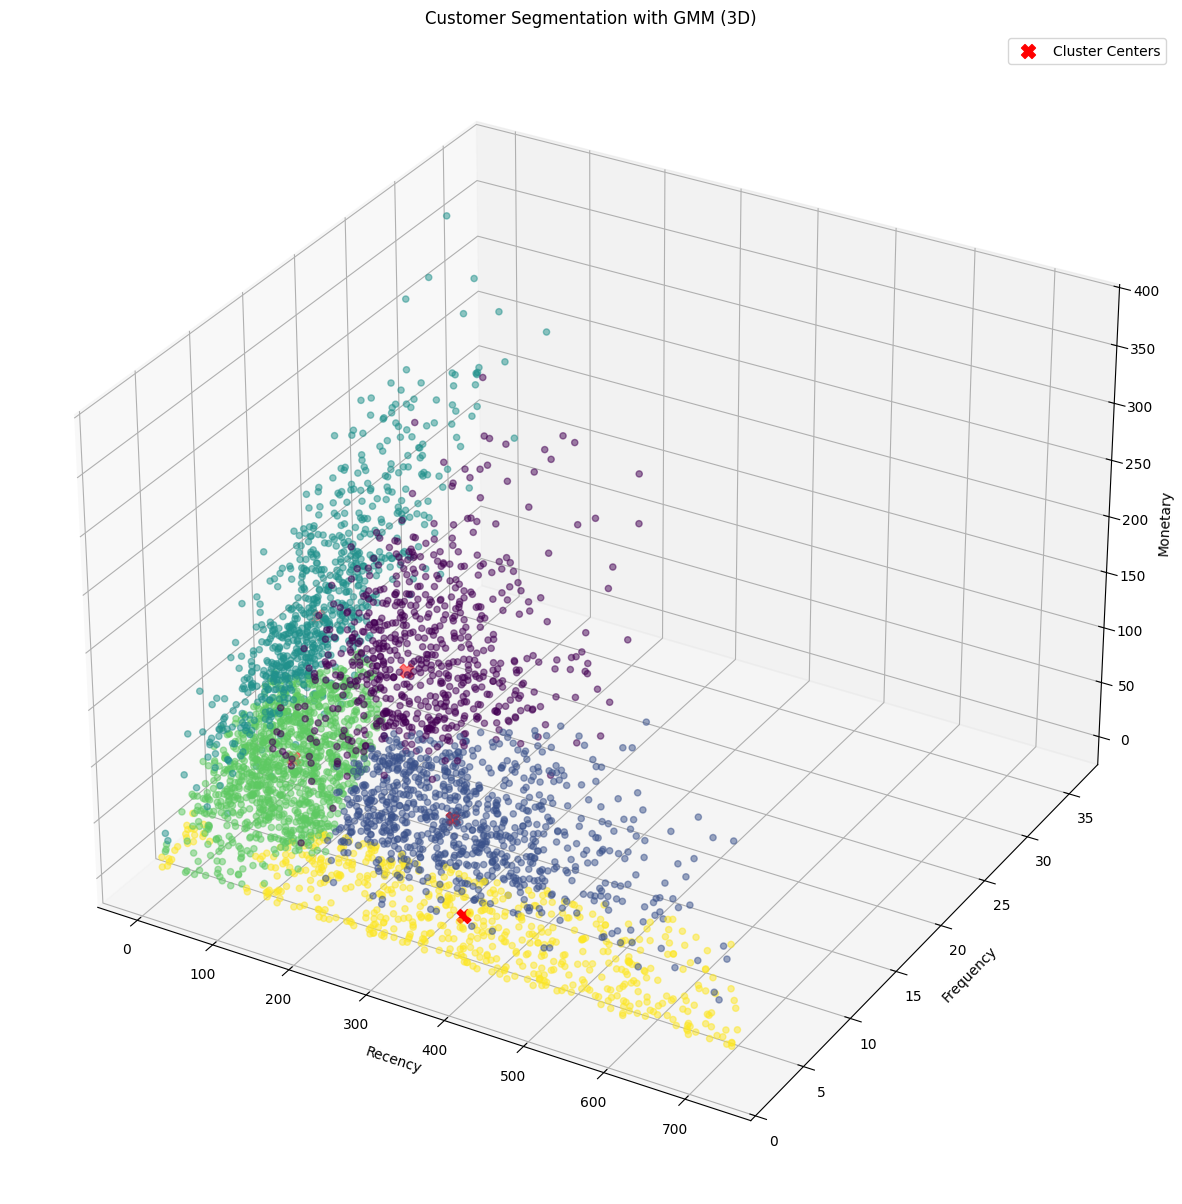

In [16]:
# Create the figure for 3D plotting
fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(111, projection='3d')

# Plot the customer points (Recency, Frequency, Monetary)
scatter = ax.scatter(
    df['Recency'], df['Frequency'], df['Monetary'],
    c=df['cluster'], cmap='viridis', alpha=0.5
)

# Get GMM centers (means_)
centroids = gmm_model.means_
centers = scaler.inverse_transform(centroids)

# Plot the centers only with Recency, Frequency, and Monetary (3D)
ax.scatter(
    centers[:, 0], centers[:, 1], centers[:, 2],
    c='red', s=100, marker='X', label='Cluster Centers'
)

# Set labels and title for the plot
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('Customer Segmentation with GMM (3D)')

# Add a legend
ax.legend()

# Show the plot
plt.show()

**Comment:**
- The GMM model with 5 clusters effectively segments customers based on RFM features. 
- The clusters are well-distributed and capture overlapping behaviors, making this segmentation useful for targeted marketing and customer strategy.